## Retail Recommendation System — Item-Based CF + User-Based CF

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import random


## Generate Synthetic Retail Data

In [12]:
num_users = 50
items = [
    "Milk", "Bread", "Eggs", "Butter", "Cheese", "Yogurt", "Juice", "Tea", "Coffee", "Sugar",
    "Rice", "Pasta", "Tomato Sauce", "Cereal", "Biscuits", "Chips", "Chocolate", "Shampoo",
    "Soap", "Toothpaste", "Detergent", "Cooking Oil", "Flour", "Salt", "Spices", "Chicken",
    "Beef", "Fish", "Apples", "Bananas", "Oranges", "Grapes", "Potatoes", "Onions", "Carrots",
    "Tomatoes", "Cucumber", "Lettuce", "Peas", "Corn", "Beans", "Ketchup", "Mayonnaise",
    "Mustard", "Pickles", "Ice Cream", "Juicy Candy", "Coke", "Sprite", "Water Bottle"
]
num_items = len(items)

data = []
for u in range(num_users):
    bought_items = random.sample(items, random.randint(5, 15))
    for it in bought_items:
        count = random.randint(1, 5)
        data.append([f"user_{u}", it, count])

df = pd.DataFrame(data, columns=["user", "item", "count"])
df = df.groupby(["user", "item"], as_index=False).sum()
df.head()

,user,item,count
0,user_0,Apples,3
1,user_0,Beans,3
2,user_0,Biscuits,4
3,user_0,Bread,1
4,user_0,Cucumber,3


## Build User-Item Matrix

In [13]:
user_item_matrix = df.pivot(index="user", columns="item", values="count").fillna(0)

## Train/Test Split (Leave-One-Out)

In [14]:
train_matrix = user_item_matrix.copy()
test_data = []
for u in train_matrix.index:
    user_items = train_matrix.loc[u]
    purchased = user_items[user_items > 0]
    if len(purchased) > 0:
        held_out = random.choice(purchased.index.tolist())
        train_matrix.loc[u, held_out] = 0
        test_data.append((u, held_out))

## Item-Based Collaborative Filtering (Cosine Similarity)

In [15]:
item_matrix = train_matrix.T
item_similarity = cosine_similarity(item_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_matrix.index, columns=item_matrix.index)


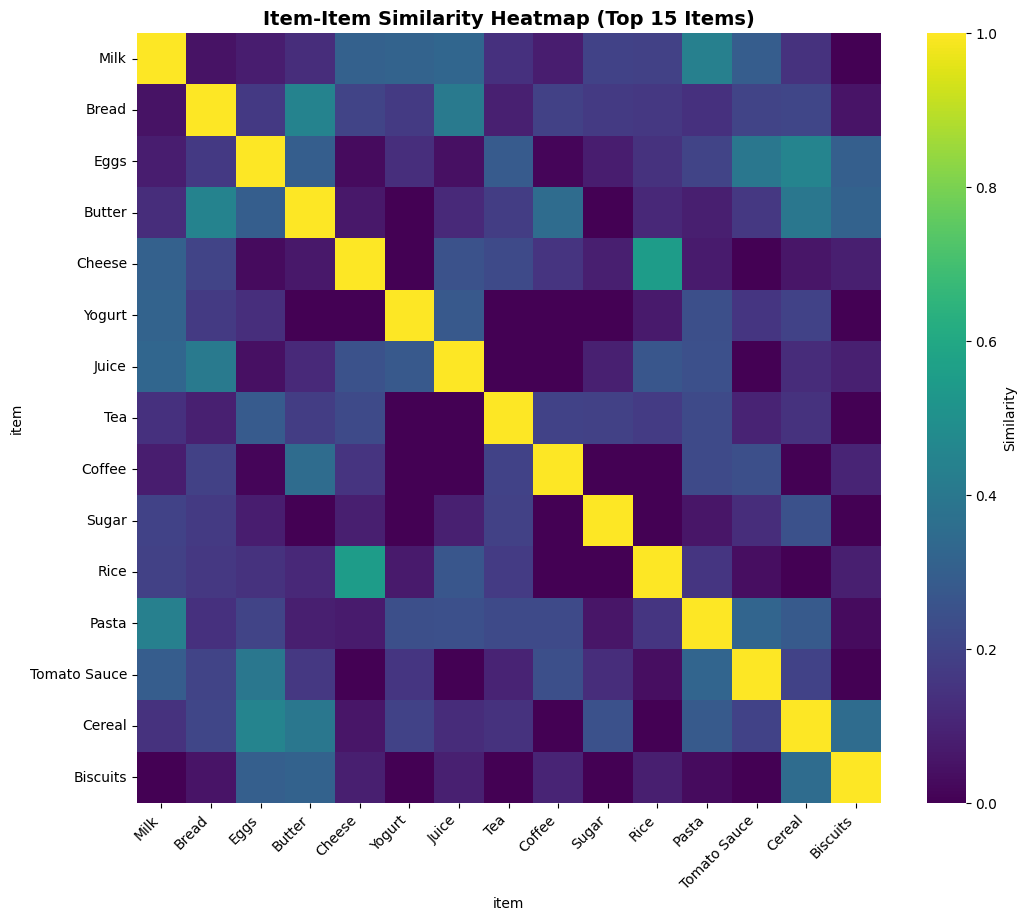

In [ ]:
# Visualization: Item Similarity Heatmap 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Pick top 15 items (to keep it readable)
subset_items = item_similarity_df.loc[items[:15], items[:15]]

# "viridis" is smooth, modern, and perceptually uniform
sns.heatmap(
    subset_items,
    annot=False,
    cmap="viridis",     # color scheme
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Similarity'}
)

plt.title("Item-Item Similarity Heatmap (Top 15 Items)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()


## Item-Based Recommender Function

In [16]:
def recommend_items_itemCF(user, k=5):
    user_vector = train_matrix.loc[user]
    scores = user_vector @ item_similarity_df
    scores = scores.drop(user_vector[user_vector > 0].index)  # drop already purchased
    return scores.sort_values(ascending=False).head(k)

## User-Based Collaborative Filtering (Cosine Similarity)

In [17]:
user_matrix_norm = normalize(train_matrix)
user_similarity = cosine_similarity(user_matrix_norm)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)

## User-Based Recommender Function

In [18]:
def recommend_items_userCF(user, k=5):
    similar_users = user_similarity_df[user].drop(user)
    top_users = similar_users.sort_values(ascending=False).head(10)
    weighted_scores = train_matrix.loc[top_users.index].T @ top_users
    already = train_matrix.loc[user]
    weighted_scores = weighted_scores.drop(already[already > 0].index)
    return weighted_scores.sort_values(ascending=False).head(k)

## Precision@K Evaluation

In [19]:
def precision_at_k(recommender, k=5):
    hits = 0
    total = len(test_data)
    for user, held_item in test_data:
        recs = recommender(user, k)
        if held_item in recs.index:
            hits += 1
    return hits / total

precision_itemCF = precision_at_k(recommend_items_itemCF, k=5)
precision_userCF = precision_at_k(recommend_items_userCF, k=5)
print(f"Precision@5 ItemCF: {precision_itemCF:.3f}")
print(f"Precision@5 UserCF: {precision_userCF:.3f}")


Precision@5 ItemCF: 0.040
Precision@5 UserCF: 0.040


## Example Recommendations for One User

In [20]:
example_user = random.choice(train_matrix.index)
print("User:", example_user)
print("Items already bought:", user_item_matrix.loc[example_user][user_item_matrix.loc[example_user] > 0].index.tolist())
print("Item-based Recommendations:", recommend_items_itemCF(example_user, k=5).index.tolist())
print("User-based Recommendations:", recommend_items_userCF(example_user, k=5).index.tolist())

User: user_41
Items already bought: ['Carrots', 'Chocolate', 'Eggs', 'Juice', 'Milk', 'Yogurt']
Item-based Recommendations: ['Spices', 'Pasta', 'Peas', 'Cheese', 'Toothpaste']
User-based Recommendations: ['Spices', 'Pasta', 'Peas', 'Water Bottle', 'Salt']
